# Initialisation GasConsumption and VWAP

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta

path='Hedging/HedgeQuarter.xlsx'
xls=pd.ExcelFile(path)
Forward=pd.read_excel(xls,'ForwardPriceMonthly') #Par Mois laisse en mois
VWAP_customers=pd.read_excel(xls,'VWAPCustomers') #Par mois laisse en mois
Consumption_gas=pd.read_excel(xls,'ComsumptionGas2018-2019') #Par Heure passe par mois
#On vas tout convertir par mois car plus simple, pour les heures->jour->mois


#On commence par convertir
def Convert_hourtomonthcons(Consumption_gas):    
    s=0
    Conso_gasmois=[]
    for i in range(len(Consumption_gas)-1):
        s=s+Consumption_gas['Gas'][i]
        if Consumption_gas['Date'][i+1].month!=Consumption_gas['Date'][i].month:
            Conso_gasmois.append(s)
            s=0
    return Conso_gasmois

def Convert_hourtodaycons(Consumption_gas):    
    s=0
    Conso_gasday=[]
    for i in range(len(Consumption_gas)-1):
        s=s+Consumption_gas['Gas'][i]
        if Consumption_gas['Date'][i+1].day!=Consumption_gas['Date'][i].day:
            Conso_gasday.append(s)
            s=0
    return Conso_gasday

ConsomationGasMonth=Convert_hourtomonthcons(Consumption_gas) #Conversion d'heure a mois

Consumption_gas=pd.DataFrame(ConsomationGasMonth,index=pd.date_range(start = pd.to_datetime('2018-01'),
                             periods = len(ConsomationGasMonth), freq='M'), columns = ['Conso Gas']) # consommation de gas KWH
VWAP_customers=pd.DataFrame(VWAP_customers['VWAP_customers'].values,index=pd.date_range(start = pd.to_datetime('2018-01'),
                             periods = len(VWAP_customers), freq='M'), columns = ['VWAP_customers'])

# Iniatialisation of gas price over 2016

In [ ]:
dataforward=pd.ExcelFile('ForwardPrice2016.xlsx')
gas=pd.read_excel(dataforward,'Gas')
gas.keys()
gas=gas.drop('Delivery\Today',1)


In [ ]:

gas=pd.DataFrame(gas.values,index=pd.date_range(start = pd.to_datetime('2017-01-01'),
                             periods = len(gas), freq='M'),columns=gas.keys())

In [ ]:
day=pd.to_datetime('2018-01-31')
gas.loc[pd.to_datetime('2019-01-31')].plot()

## Creation of a Dataframe which do a synthesis of all the Data per month

In [ ]:
synthese=VWAP_customers.merge(Consumption_gas,right_index=True,left_index=True)

# Choose of Today Date, for the Forward Price

In [ ]:
Today=pd.to_datetime('23-09-2016')
synthese=synthese.merge(gas[Today],right_index=True,left_index=True)
synthese=synthese.rename(columns={Today:'Today'})


# Function calculating the moving Average

In [ ]:
def calcul_MM(gas,nbr_week): #MM
    Total=[]
    for i in gas.index:
        mois=[]
        for j in gas.keys():
            s=np.mean(gas.loc[i,j-timedelta(days=nbr_week*7):j])
            mois.append(s)
        Total.append(mois)
    return Total
TotalMM20=calcul_MM(gas,2)
MM20=pd.DataFrame(TotalMM20,index=pd.date_range(start = pd.to_datetime('2017-01-01'),
                             periods = len(gas), freq='M'),columns=gas.keys()) #CalculMM20

# Vision of the moving average 20 Days, it smooth the curve

In [ ]:
plt.plot(TotalMM20[5][:],label='MM20')
plt.plot(gas.loc[pd.to_datetime('2017-06-30')].values,label='FP')

plt.legend()

# Adding the Moving average to the synthesis

In [ ]:
synthese=synthese.merge(MM20[Today],left_index=True,right_index=True)

# Defining the Date of the previous Week, and put the moving average in the synthesis

In [ ]:
LastWeek=Today-timedelta(days=7)

In [ ]:
synthese=synthese.merge(MM20[LastWeek],left_index=True,right_index=True)

# Function which gives the signal to Hedge !!!

In [ ]:

def Signal(MarketPrice,VWAP,TodayMM20,LastWeekMM20):
    Etat=[]
    for i in range(len(VWAP)):
        if MarketPrice[i]>VWAP[i]+0.25 and TodayMM20[i]>LastWeekMM20[i]+0.20: #the market price above 1 euros avec the mm superiour than last week by 0,15 cents            15
            Etat.append('Long')

        elif MarketPrice[i]>VWAP[i]+0.25 and TodayMM20[i]<LastWeekMM20[i]-0.20:
            Etat.append('Short')

        elif MarketPrice[i]<VWAP[i]-0.5 and TodayMM20[i]>LastWeekMM20[i]+0.40:
            Etat.append('Long')

        elif MarketPrice[i]<VWAP[i]-0.5 and TodayMM20[i]<LastWeekMM20[i]-0.40:
            Etat.append('Short')

        elif MarketPrice[i]>=VWAP[i]-0.25 and MarketPrice[i]<=VWAP[i]+0.5:
            Etat.append('Inbox')
        else :
            Etat.append('Flat')
            
    return Etat




# Putting the state in the synthesis

In [ ]:
synthese['Etat']=Signal(synthese['Today'],synthese['VWAP_customers'],synthese[Today],synthese[LastWeek])

# put the gas consumption in MWH

In [ ]:
synthese['Conso Gas']=synthese['Conso Gas']/1000

# Putting the previous hedge to 0

In [ ]:
synthese['PreviousHedge']=0.

# Function for the hedging strategy 

In [ ]:
def calculate_volume_hedged(MMToday,MMLastWeek,Volume):
    Delta=MMToday-MMLastWeek
    if Delta >4:
        return 1.2*Volume
    elif Delta>=0 and Delta<=4:
        return ((Volume*np.sqrt(Delta))/(np.pi))+Volume
    elif Delta >-4 and Delta<0  :
        return (-(Volume*np.sqrt(-(Delta)))/(np.pi))+Volume
    else:
        return 0.8*Volume
    
def Volatility(today,Tdelivery): #en jour
    if ((Tdelivery-today).days/90)<(30/90):
        return (1/5)*(30/90)**(-2/5)
    else:
        return (1/5)*((Tdelivery-today).days/90)**(-2/5)
    
def coef_aggresivity(volatility,cst_aggresivity): #calcul du coefficient d'agressivity
    return 1. 
#-volatility-cst_aggresivity


def calcul_upperPrice(upperPriceBase,volatility,cst_aggresivity):
    return upperPriceBase*coef_aggresivity(volatility,cst_aggresivity) #Calcul de l'upperprice

def calcul_volume(BoundPrice,ForwardPrice,VWAP,upperPrice,VolumeBase,previous_hedge,form): #Calcul du volume
    Delta=ForwardPrice-VWAP
    if Delta>upperPrice:
        Delta=upperPrice
    if Delta<-upperPrice:
        Delta=-upperPrice
    if Delta>0:
        if form=='linear':
            return (((BoundPrice/upperPrice)*VolumeBase)*Delta) - previous_hedge #lineaire # Bound price : 0.20 percent
        if form=='quadratic':
            return ((BoundPrice/upperPrice**2)*VolumeBase)*Delta**2 - previous_hedge
        if form=='squared':
            return ((BoundPrice/np.sqrt(upperPrice))*VolumeBase)*np.sqrt(Delta) - previous_hedge
    if Delta<0:
        if form=='linear':
            return (((BoundPrice/upperPrice)*VolumeBase)*Delta) - previous_hedge #lineaire # Bound price : 0.20 percent
        if form=='quadratic':
            return -((BoundPrice/upperPrice**2)*VolumeBase)*Delta**2 - previous_hedge
        if form=='squared':
            return -((BoundPrice/np.sqrt(upperPrice))*VolumeBase)*np.sqrt(-Delta) - previous_hedge 


    
def Hedging2(ForwardPrice,VWAP,Volume,Today,Etat,upperPriceBase,cst_agressivity,previousHedge,BoundPrice,form):
    Volume=-Volume
    VolumeHedged=[]
    ValueHedged=[]
    cost_transac=[]
    print(' Hedging Strategy for '+str(Today.day)+'-'+str(Today.month)+'-'+str(Today.year)+' :')
    
    for i in range(len(ForwardPrice)):
        if Etat[i]=='Short':
                volatility=Volatility(Today,Etat.index[i])
                upperPrice=calcul_upperPrice(upperPriceBase,volatility,cst_agressivity)
                new_volume=calcul_volume(BoundPrice,ForwardPrice[i],VWAP[i],upperPrice,Volume[i],previousHedge[i],form)
                costtrans=0.1*abs(new_volume)
                ValueSell=-(new_volume*ForwardPrice[i]) #- costtrans
                if new_volume<0:
                    print('For Delivery in %d-%d ,Sold %f MWH,and we receive is %f Euros' % (Etat.index[i].year,Etat.index[i].month,new_volume,ValueSell))
                else:
                    print('For Delivery in %d-%d ,Buy %f MWH,and we pay is %f Euros' % (Etat.index[i].year,Etat.index[i].month,new_volume,ValueSell))
                VolumeHedged.append(new_volume)
                ValueHedged.append(ValueSell)
                cost_transac.append(costtrans)
        elif Etat[i]=='Long':
                volatility=Volatility(Today,Etat.index[i])
                upperPrice=calcul_upperPrice(upperPriceBase,volatility,cst_agressivity)
                new_volume=calcul_volume(BoundPrice,ForwardPrice[i],VWAP[i],upperPrice,Volume[i],previousHedge[i],form)
                costtrans=0.1*abs(new_volume) #long
                ValueSell=-(new_volume*ForwardPrice[i]) #- costtrans
                if new_volume<0:
                    print('For Delivery in %d-%d ,Sold %f MWH,and we receive is %f Euros' % (Etat.index[i].year,Etat.index[i].month,new_volume,ValueSell))
                else:
                    print('For Delivery in %d-%d ,Buy %f MWH,and we pay is %f Euros' % (Etat.index[i].year,Etat.index[i].month,new_volume,ValueSell))   
                VolumeHedged.append(new_volume)
                ValueHedged.append(ValueSell)
                cost_transac.append(costtrans)
        elif Etat[i]=='Inbox':
                new_volume=-previousHedge[i]
                costtrans=0.1*abs(new_volume) #flt
                ValueSell=-(new_volume*ForwardPrice[i]) #- costtrans
                if new_volume<0:
                    print('For Delivery in %d-%d ,Sold %f MWH,and we receive is %f Euros (100)' % (Etat.index[i].year,Etat.index[i].month,new_volume,ValueSell))
                if new_volume>0:
                    print('For Delivery in %d-%d ,Buy %f MWH,and we pay is %f Euros 100' % (Etat.index[i].year,Etat.index[i].month,new_volume,ValueSell))  
                VolumeHedged.append(new_volume)
                ValueHedged.append(ValueSell)
                cost_transac.append(costtrans)
        else:
                VolumeHedged.append(0)
                ValueHedged.append(0)
                cost_transac.append(0)
    return (VolumeHedged,ValueHedged,cost_transac)
    


In [ ]:
ojd=pd.to_datetime('30-09-2016')
deliv=pd.to_datetime('30-09-2021')

Volatility(ojd,deliv)

In [ ]:
cst_agressivity=0. #constante empirique
upperPriceBase=4 #Calcul grace a la variation standart

Hedg=Hedging2(synthese['Today'],synthese['VWAP_customers'],synthese['Conso Gas'],Today,synthese['Etat'],upperPriceBase,cst_agressivity,synthese['PreviousHedge'],0.2,'quadratic')

# Vue of synthese

In [1633]:
synthese

,VWAP_customers,Conso Gas,Today,2016-09-23 00:00:00,2016-09-16 00:00:00,Etat,PreviousHedge
2018-01-31,17.791018,-2313.432807,17.074686,16.569187,16.376859,Flat,0.0
2018-02-28,17.792241,-2043.327181,17.007285,16.505285,16.312524,Flat,0.0
2018-03-31,17.762505,-1877.761861,16.570338,16.068934,15.869239,Flat,0.0
2018-04-30,17.691166,-1341.883546,15.878688,15.375273,15.163764,Flat,0.0
2018-05-31,17.626902,-908.000000,15.406689,14.899984,14.680117,Flat,0.0
2018-06-30,17.832523,-891.000000,15.278502,14.767605,14.544910,Flat,0.0
2018-07-31,17.924734,-895.000000,15.438503,14.923564,14.702399,Flat,0.0
2018-08-31,17.935999,-906.000000,15.693948,15.179263,14.959195,Flat,0.0
2018-09-30,17.972764,-1067.000000,15.979475,15.470326,15.249733,Flat,0.0
2018-10-31,18.123518,-1965.000000,16.323514,15.823461,15.600857,Flat,0.0


# SIMULATION

In [ ]:
synthese['PreviousHedge']=0.
synthese['Valueofhedge']=0.
synthese['Nbr transaction']=0
synthese['Cost of transaction']=0.
cst_agressivity=0. #constante empirique
upperPriceBase=4 #Calcul grace a la variation standart
if Today in synthese.columns:
    synthese= synthese.drop([Today,LastWeek],axis=1)
#del synthese[LastWeek]
for date in gas.keys()[20:60]:
    Today=date
    LastWeek=Today-timedelta(days=7)
    #ForwardPrice
    synthese= synthese.drop(['Today'],axis=1)
    synthese=synthese.merge(gas[Today],right_index=True,left_index=True)
    synthese=synthese.rename(columns={Today:'Today'})
    #MM20
    synthese=synthese.merge(MM20[Today],left_index=True,right_index=True)
    synthese=synthese.merge(MM20[LastWeek],left_index=True,right_index=True)
    synthese['Etat']=Signal(synthese['Today'],synthese['VWAP_customers'],synthese[Today],synthese[LastWeek])
    Hedgi=Hedging2(synthese['Today'],synthese['VWAP_customers'],synthese['Conso Gas'],Today,synthese['Etat'],upperPriceBase,cst_agressivity,synthese['PreviousHedge'],0.3,'quadratic')
    synthese['PreviousHedge']=synthese['PreviousHedge']+Hedgi[0]
    synthese['Valueofhedge']=synthese['Valueofhedge']+Hedgi[1]
    synthese['Cost of transaction']=synthese['Cost of transaction']+Hedgi[2]
    synthese= synthese.drop([Today,LastWeek],axis=1)

# Test

# Value given or received

In [ ]:
synthese['Valueofhedge'].sum()

In [ ]:
Value_Portfolio=0
for i in range(len(synthese['Valueofhedge'])):
    Value_Portfolio=Value_Portfolio+synthese['VWAP_customers'][i]*(-synthese['Conso Gas'][i])

In [ ]:
Value_Portfolio

In [1638]:
100*(synthese['Valueofhedge'].sum()/Value_Portfolio)

12.05205427792621

# TEST DU P&L

In [1644]:
PL=pd.DataFrame(index=pd.date_range(start = pd.to_datetime('2018-01-31'),
                             periods = len(synthese), freq='M'))

## Case of volume correlated with price

In [1645]:
PL['VWAP']=synthese['VWAP_customers']
PL['Spot Price']=synthese['Today'] #RANDOM EST FIXE
PL['Expected Conso']=-synthese['Conso Gas'] #consommation en positif
PL['Hedge Volume']=PL['Expected Conso']+synthese['PreviousHedge']
PL['Real Conso']=0
for i in range(len(PL)):
    if PL['Spot Price'][i]>PL['VWAP'][i]:
        PL['Real Conso'][i]=(1+abs(np.random.normal(1,0.1)-1))*PL['Expected Conso'][i]
    else:
        PL['Real Conso'][i]=(1-abs(np.random.normal(1,0.1)-1))*PL['Expected Conso'][i]
#PL['Real Conso']=PL['Hedge Volume']
PL['Value Hedge']=synthese['Valueofhedge']
PL['Open position Hedge']=(PL['Hedge Volume']-PL['Real Conso'])
PL['Open position Unhedged']=(PL['Expected Conso']-PL['Real Conso'])
PL['PL Hedge']=PL['Real Conso']*PL['VWAP'] + PL['Value Hedge'] - PL['Expected Conso']*PL['VWAP'] -(PL['Real Conso']-PL['Hedge Volume'])*PL['Spot Price']
PL['PL Unhedged']=PL['Real Conso']*PL['VWAP']  - PL['Expected Conso']*PL['VWAP'] +(PL['Expected Conso']-PL['Real Conso'])*PL['Spot Price']

C:\Users\sasma\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [1647]:
PL

,VWAP,Spot Price,Expected Conso,Hedge Volume,Real Conso,Value Hedge,Open position Hedge,Open position Unhedged,PL Hedge,PL Unhedged
2018-01-31,17.791018,17.679553,2313.432807,2313.432807,2054,-25.324160,259.432807,259.432807,-54.242051,-28.917891
2018-02-28,17.792241,17.626194,2043.327181,2043.327181,1852,-37.286038,191.327181,191.327181,-69.055408,-31.769369
2018-03-31,17.762505,17.194844,1877.761861,1877.761861,1842,-113.195417,35.761861,35.761861,-133.496028,-20.300612
2018-04-30,17.691166,16.487845,1341.883546,1228.641181,1252,1795.706189,-23.358819,89.883546,-179.575106,-108.158721
2018-05-31,17.626902,15.926983,908.000000,892.427946,861,121.740917,31.427946,47.000000,-206.171119,-79.896197
2018-06-30,17.832523,15.624013,891.000000,880.654430,836,-64.809907,44.654430,55.000000,-347.917308,-121.468093
2018-07-31,17.924734,15.558204,895.000000,830.252250,844,812.862009,-13.747750,51.000000,-315.189712,-120.692994
2018-08-31,17.935999,15.674397,906.000000,889.264950,887,144.180467,2.264950,19.000000,-161.101799,-42.970451
2018-09-30,17.972764,15.945283,1067.000000,960.811161,906,1698.894411,54.811161,161.000000,-320.741040,-326.424355
2018-10-31,18.123518,16.369193,1965.000000,1911.655335,1910,813.514587,1.655335,55.000000,-156.182414,-96.487893


# Simulation of different volume

In [ ]:
simulationhedge=pd.DataFrame(index=PL.index)
simulationunhedge=pd.DataFrame(index=PL.index)
for i in range(1000):
    for j in range(len(PL)):
        if PL['Spot Price'][j]>PL['VWAP'][j]:
            PL['Real Conso'][j]=(1+abs(np.random.normal(1,0.1)-1))*PL['Expected Conso'][j]
        else:
            PL['Real Conso'][j]=(1-abs(np.random.normal(1,0.1)-1))*PL['Expected Conso'][j]
    #PL['Real Conso']=PL['Hedge Volume']
    simulationhedge['essai n '+str(i)]=PL['Real Conso']*PL['VWAP'] + synthese['Valueofhedge'] - PL['Expected Conso']*PL['VWAP'] -(PL['Real Conso']-PL['Hedge Volume'])*PL['Spot Price']
    simulationunhedge['essai n '+str(i)]=PL['Real Conso']*PL['VWAP']  - PL['Expected Conso']*PL['VWAP'] +(PL['Expected Conso']-PL['Real Conso'])*PL['Spot Price']

C:\Users\sasma\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
comparaison=pd.DataFrame(index=['Mean Hedge','Mean Unhedge','95% Hedge','95% Unhedged'])

In [ ]:
for date in simulationhedge.index:
    MH=simulationhedge.loc[date].mean()
    MU=simulationunhedge.loc[date].mean()
    QH=np.percentile(simulationhedge.loc[date],95)
    QU=np.percentile(simulationunhedge.loc[date],95)
    comparaison[date]=[MH,MU,QH,QU]

In [ ]:
comparaison

In [ ]:
comparaison.keys()

In [ ]:
plt.plot(comparaison.keys(),comparaison.loc['Mean Hedge'].values,label='Hedge')
plt.plot(comparaison.keys(),comparaison.loc['Mean Unhedge'].values,label='UnHedge')
plt.plot(comparaison.keys(),comparaison.loc['95% Hedge'].values,label='95%')
plt.plot(comparaison.keys(),comparaison.loc['95% Unhedged'].values,label='95% unhedged')
plt.legend()

## Case Volume not correlated with price

In [1608]:
PL['Real Conso']=np.random.normal(1,0.1,len(synthese))*PL['Expected Conso']
PL['Open position']=(PL['Expected Conso']-PL['Real Conso'])
PL['PL Hedge']=PL['Real Conso']*PL['VWAP'] +synthese['Valueofhedge'] - PL['Expected Conso']*PL['VWAP'] -(PL['Real Conso']-PL['Hedge Volume'])*PL['Spot Price']
PL['PL Unhedged']=PL['Real Conso']*PL['VWAP'] - PL['Expected Conso']*PL['VWAP'] +(PL['Expected Conso']-PL['Real Conso'])*PL['Spot Price']

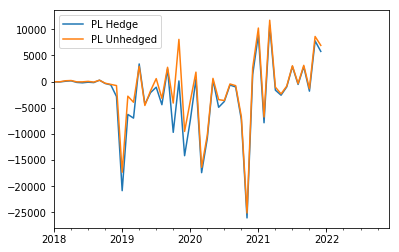

In [1609]:
#PL['PL Hedge'].plot()
PL['PL Hedge'].plot()
PL['PL Unhedged'].plot()
plt.legend()

In [1610]:
PL.describe()

,VWAP,Spot Price,Expected Conso,Hedge Volume,Real Conso,Open position,PL Hedge,PL Unhedged
count,60.000000,48.000000,60.000000,60.000000,60.000000,60.000000,48.000000,48.000000
mean,19.116814,16.533248,17273.111403,15283.796561,16716.488589,556.622813,-2545.987197,-1436.968452
std,0.793508,0.639112,14941.285187,13618.375208,14804.284605,2383.552282,6858.770994,6503.058523
min,17.626902,15.514481,891.000000,842.373222,861.509585,-5359.296324,-26063.123175,-25124.224688
25%,18.619696,15.960824,4025.201856,3991.100032,3613.576039,-165.395685,-4545.960134,-3495.457598
50%,19.282759,16.449059,11479.756784,9174.083500,11104.226062,214.653015,-649.662713,-424.883053
75%,19.497510,17.026482,30062.773067,27548.585149,28277.674538,1002.281531,171.190591,574.513983
max,20.475836,17.679553,52672.281273,50473.498951,50903.119025,8994.526339,10788.778815,11720.433792
